In [1]:
%pip install matplotlib
%pip install seaborn
%pip install statsmodels==0.13.0
%pip install scikit-learn
%pip install pmdarima

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
You should consider upgrading via the '/usr/local/opt/python@3.9/bin/python3.9 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work i

In [2]:
import json
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.dates as mplt_dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

## Read Data

In [3]:
business_df = pd.read_json('yelp_academic_dataset_business.json', lines=True)
checkin_df = pd.read_json('yelp_academic_dataset_checkin.json', lines=True)

In [4]:
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


In [5]:
checkin_df.head()

,business_id,date
0,--0r8K_AQ4FZfLsX3ZYRDA,2017-09-03 17:13:59
1,--0zrn43LEaB4jUWTQH_Bg,"2010-10-08 22:21:20, 2010-11-01 21:29:14, 2010..."
2,--164t1nclzzmca7eDiJMw,"2010-02-26 02:06:53, 2010-02-27 08:00:09, 2010..."
3,--2aF9NhXnNVpDV0KS3xBQ,"2014-11-03 16:35:35, 2015-01-30 18:16:03, 2015..."
4,--2mEJ63SC_8_08_jGgVIg,"2010-12-15 17:10:46, 2013-12-28 00:27:54, 2015..."


## Join Restaurants with Checkin Data

In [6]:
restaurant_checkin_df = business_df.merge(checkin_df, how='inner', on='business_id')
restaurant_checkin_df = restaurant_checkin_df[['business_id', 
                                               'name', 
                                               'city', 
                                               'state', 
                                               'is_open', 
                                               'stars', 
                                               'review_count', 
                                               'date']]
df = restaurant_checkin_df.sort_values('review_count', ascending=False)
df

,business_id,name,city,state,is_open,stars,review_count,date
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,"2010-01-17 23:35:23, 2010-01-20 18:17:56, 2010..."
98237,PrsvO1rzkgg6qFizlAoEtg,Mike's Pastry,Boston,MA,1,4.0,7298,"2010-01-18 18:40:17, 2010-02-02 17:39:30, 2010..."
36545,OQ2oHkcWA8KNC1Lsvj1SBA,Screen Door,Portland,OR,1,4.5,7219,"2010-02-13 17:19:02, 2010-02-21 04:58:36, 2010..."
22051,zioLxtBc9THNS2TOn9xW1w,Pok Pok,Portland,OR,0,4.0,6221,"2010-01-17 04:40:16, 2010-02-14 02:01:09, 2010..."
125647,y2w6rFaO0XEiG5mFfOsiFA,Neptune Oyster,Boston,MA,1,4.5,5115,"2010-01-18 22:30:38, 2010-01-24 23:19:56, 2010..."
...,...,...,...,...,...,...,...,...
127957,D83NMg95YwIzUnL9zhV1Eg,Nails At Last,Saugus,MA,1,4.0,5,2012-05-26 13:44:01
11674,NKGn50PhwXpJo8Of1LTeTg,Greenberg Dental and Orthodontics,Deltona,FL,1,2.5,5,2014-11-10 18:52:37
2204,sVIEBHShcMRBOXYMOppgng,David King Fitness,Austin,TX,1,5.0,5,"2012-07-27 00:53:53, 2012-07-27 18:06:25, 2012..."
45309,QLO59Rwdeo-V9dSIvPRBnQ,321 Open Sesame,Kennesaw,GA,1,5.0,5,"2015-12-09 20:47:34, 2016-01-24 01:43:21"


In [7]:
work_with_one_restaurant = df[df['business_id'] == '4CxF8c3MB7VAdY8zFb2cZQ']
work_with_one_restaurant

,business_id,name,city,state,is_open,stars,review_count,date
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,"2010-01-17 23:35:23, 2010-01-20 18:17:56, 2010..."


## Pre-process Data to Explode Checkin Dates 

In [8]:
df1 = (
    work_with_one_restaurant
    .join(work_with_one_restaurant['date'].str.split(',',expand=True).stack().reset_index(1),how='outer')
    .drop(columns=['level_1','date']).rename(columns={0 : 'date'})
)
df1

,business_id,name,city,state,is_open,stars,review_count,date
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2010-01-17 23:35:23
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2010-01-20 18:17:56
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2010-01-20 20:19:13
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2010-01-23 21:22:13
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2010-01-24 22:46:48
...,...,...,...,...,...,...,...,...
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2021-01-15 04:25:42
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2021-01-22 00:53:05
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2021-01-22 01:03:22
55282,4CxF8c3MB7VAdY8zFb2cZQ,Voodoo Doughnut - Old Town,Portland,OR,1,3.5,9185,2021-01-25 19:44:37


## Aggregate Checkin's by Month 
    for Restaurant "Voodoo Doughnut - Old Town"

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.set_index('date', inplace=True)

In [10]:
rest1 = df1.resample('D')['business_id'].count().reset_index().rename(columns={'business_id': 'checkins'})
rest1

,date,checkins
0,2010-01-17,1
1,2010-01-18,0
2,2010-01-19,0
3,2010-01-20,2
4,2010-01-21,0
...,...,...
4024,2021-01-23,0
4025,2021-01-24,0
4026,2021-01-25,1
4027,2021-01-26,0


In [11]:
rest1['year'] = rest1['date'].dt.year
rest1['month'] = rest1['date'].dt.month
rest1['week'] = rest1['date'].dt.week
rest1['day'] = rest1['date'].dt.day

## Data Exploration

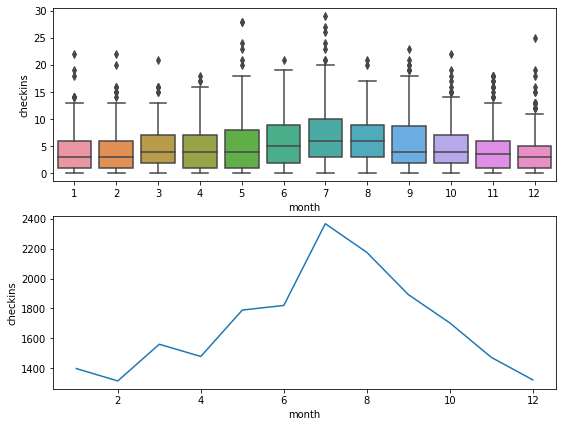

In [12]:
monthly_agg = rest1.groupby('month')['checkins'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='checkins', data=rest1, ax=axs[0])
_ = sn.lineplot(x='month', y='checkins', data=monthly_agg, ax=axs[1])

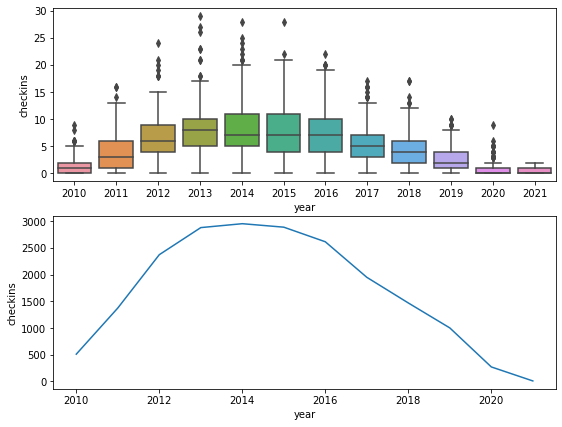

In [13]:
yearly_agg = rest1.groupby('year')['checkins'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='checkins', data=rest1, ax=axs[0])
_ = sn.lineplot(x='year', y='checkins', data=yearly_agg, ax=axs[1])

From the number of checkins vs. year plot, we can infer an increasing trend over the years up till 2013, then a plateau between 2013-2015, and then a gradual downfall after since 2015.



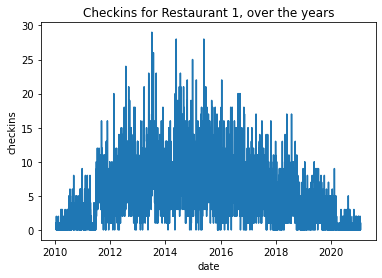

In [14]:
plot = sn.lineplot(x='date', y='checkins', data=rest1)
_ = plot.set(title='Checkins for Restaurant 1, over the years')

In [15]:
# Split the series to predict the last 12 months

temp_df = rest1.set_index('date')
train_df = temp_df.loc[:'2020-01-31'].reset_index(drop=False)                         
test_df = temp_df.loc['2020-02-01':].reset_index(drop=False)

train_df.head()

,date,checkins,year,month,week,day
0,2010-01-17,1,2010,1,2,17
1,2010-01-18,0,2010,1,3,18
2,2010-01-19,0,2010,1,3,19
3,2010-01-20,2,2010,1,3,20
4,2010-01-21,0,2010,1,3,21


# Quantitative Methods to Forecast Restaurant Checkins

## 1. Baseline Model: Seasonal Naive

In [16]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]') 

seasonal_naive_checkins = train_df[train_df['date'].astype('datetime64[D]').isin(dates)]['checkins'] 

# make a copy of the test_df and make naive predictions for the last 12 months
sn_pred_df = test_df.copy().drop('checkins', axis=1)
sn_pred_df['seasonal_naive_checkins'] =  pd.DataFrame(seasonal_naive_checkins).set_index(test_df.index)

In [17]:
sn_pred_df.head()

,date,year,month,week,day,seasonal_naive_checkins
0,2020-02-01,2020,2,5,1,3
1,2020-02-02,2020,2,5,2,1
2,2020-02-03,2020,2,6,3,6
3,2020-02-04,2020,2,6,4,2
4,2020-02-05,2020,2,6,5,1


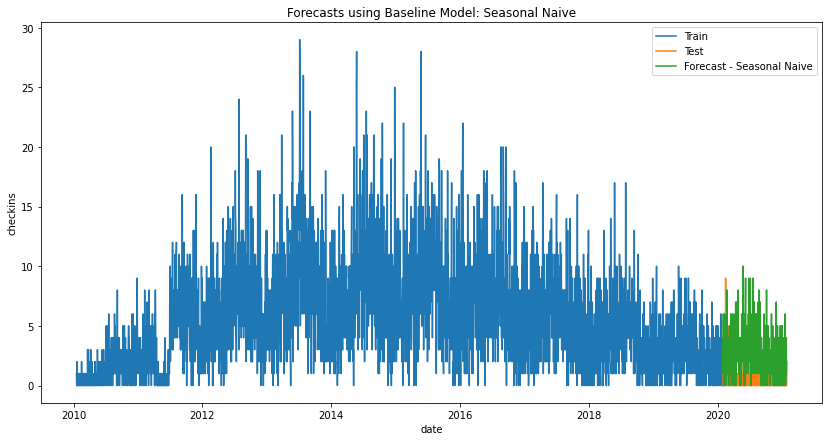

In [18]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['checkins'], label='Train')
plt.plot(test_df['date'], test_df['checkins'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_checkins'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

**Inference:** To the naked eye, the forecasts seem alright the decreasing trend is clearly captured by our naive method. However, we will formally quantify the performance using forecast accuracy metrics.

**Evaluating the Forecasts**

There are number of widely accepted forecasting metrics, and the most common metric is forecast error. The error can simply be calculated by finding the diffrence between the actual checkins value and the forecasted checkins value. For example, if 10 items are sold on a day, and you predicted 14 items to be sold, you have an error of -4.

In order to evaluate the overall forecast, we will look at metrics like mean absolute error (MAE), root mean squared error (RMSE) and a percentage error metric - mean absolute percentage error (MAPE).

**MAE:** It is the absolute value of the error, summed for each observed day, and divided by the total number of observed days.

**RMSE:** It is similar to MAE, however rather than the absolute value, the error is squared before it is summed, and then the square root is taken to normalize the units. Because we take the square of the error, we wind up punishing large forecasting errors more than small ones.

The above two metrics are scale-dependent meaning that we cannot use them to compare forecasts on different scales. MAPE on the other hand is a scale-independent metric.

**MAPE:** It can be used for meaningful comparisions, it is calculated by dividing the sum of absolute errors by sum of actual checkins to get a percentage indicator that is scaled to the actual checkins.
Let's apply the above metrics to our forecasts and see how they compare.

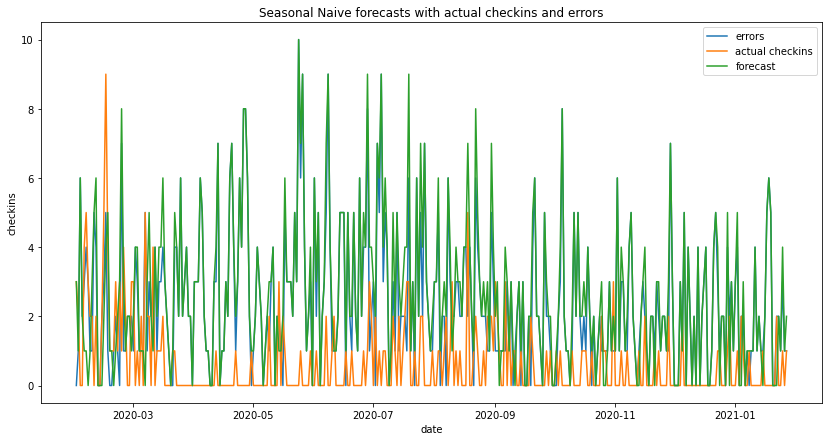

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,229,977,-748,2.414365,3.123605,381.659389


In [19]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'checkins', 'seasonal_naive_checkins']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'checkins', 'seasonal_naive_checkins']]
errors_df['errors'] = test_df['checkins'] - sn_pred_df['seasonal_naive_checkins']
errors_df.insert(0, 'model', 'Seasonal Naive') 

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, checkins=errors_df['checkins']):
    return np.sum(np.abs(err))/np.sum(checkins) * 100

result_df = errors_df.groupby('model').agg(total_checkins=('checkins', 'sum'),
                                           total_pred_checkins=('seasonal_naive_checkins', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae), 
                                           RMSE=('errors', rmse), 
                                           MAPE=('errors', mape))
    

plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['checkins'], label='actual checkins')
plt.plot(errors_df['date'], errors_df['seasonal_naive_checkins'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Seasonal Naive forecasts with actual checkins and errors')
plt.show()

result_df


The overall error is not that good using this naive baseline model, we were able to achieve a MAPE of 381.65%. We will use this as a benchmark to judge the forecast performance of the other models. 

The seasonal model just looked at the number of checkins for the same date last year. However, we can clearly see form the previous EDA plots that the checkin trend is on a downward slope. Therefore, we run the risk of providing inflated forecasts if we base it on previous years (same date) checkins.

We will next experiment with more advanced models like Exponential Smoothing, ARIMA, Regressors

## Time Series Decomposition Plot

A time series decomposition plot allows us to observe the seasonality, trend, and error/remainder terms of a time series. These three components are a crucial part of the Exponential Smoothing models. Therfore, the decomposition plot helps in deciding the type of Exponential Smoothing Model to use for our forecasts.

In [20]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['checkins'] = ts_decomp_df['checkins'].astype(float)
ts_decomp_df.head()

,checkins,year,month,week,day
date,,,,,
2010-01-17,1.0,2010,1,2,17
2010-01-18,0.0,2010,1,3,18
2010-01-19,0.0,2010,1,3,19
2010-01-20,2.0,2010,1,3,20
2010-01-21,0.0,2010,1,3,21


<Figure size 432x288 with 0 Axes>

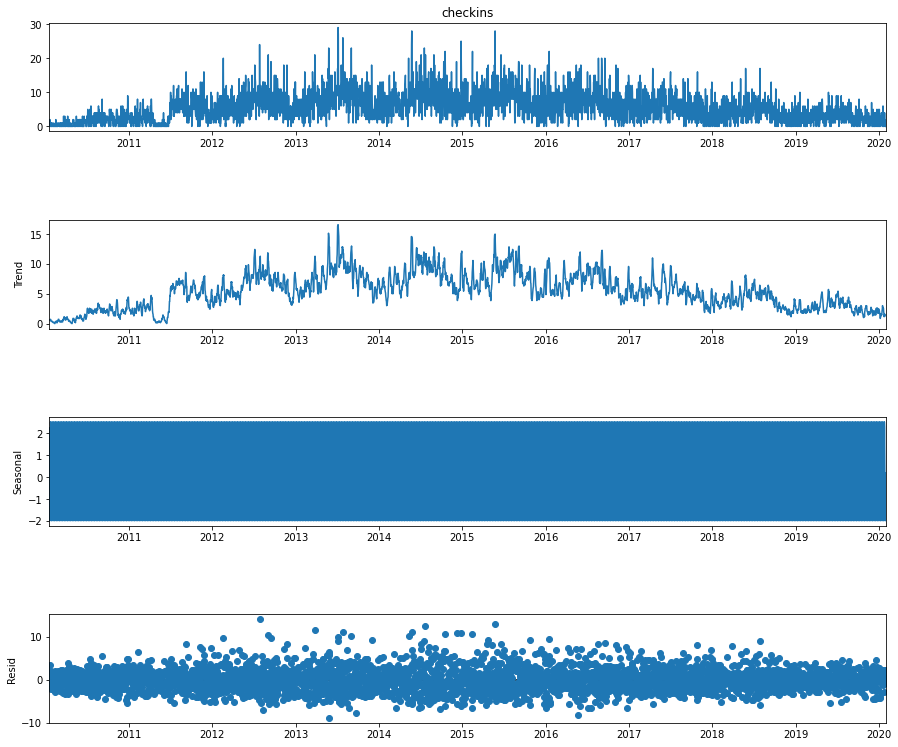

In [21]:
result = seasonal_decompose(ts_decomp_df['checkins'], model='additive')
fig = plt.figure()  
fig = result.plot()
fig.set_size_inches(14, 12)

##  Determine Error, Trend and Seasonality

An ETS model has three main components: error, trend, and seasonality. Each can be applied either additively, multiplicatively, or not at all. We will use the above Times Series Decomposition Plot to determine the additive or multiplicative property of the thre components.

1. Trend - If the trend plot is linear then we apply it additively (A). If the trend line grows or shrinks exponentially, we apply it multiplicatively (M). If there is no clear trend, no trend component is included (N).

2. Seasonal - If the peaks and valleys for seasonality are constant over time, we apply it additively (A). If the size of the seasonal fluctuations tends to increase or decrease with the level of time series, we apply it multiplicatively (M). If there is no seasonality, it is not applied (N).

3. Error - If the error plot has constant variance over time (peaks and valleys are about the same size), we apply it additively (A). If the error plot is fluctuating between large and small errors over time, we apply it multiplicatively (M).

**Inference:** For our checkins data, there is no trend or seasonality over timme, so we will not apply trend and seasonality. The error component is fluctuating between large and small errors, so we will apply it multiplicatively (M).

We will use a Exponential Smoothing, a commonly-used local statistical algorithm for time-series forecasting. The Exponential Smoothing method can be defined in terms of an ETS framework, in which the components are calculated using a smoothing technique.

**What is Exponential Smoothing?**
This is a very popular scheme to produce a smoothed Time Series. Whereas in Single Moving Averages the past observations are weighted equally, Exponential Smoothing assigns exponentially decreasing weights as the observation get older. In other words, recent observations are given relatively more weight in forecasting than the older observations.
In the case of moving averages, the weights assigned to the observations are the same and are equal to 1/N. In exponential smoothing, however, there are one or more smoothing parameters to be determined (or estimated) and these choices determine the weights assigned to the observations.

There are 3 kinds of smoothing techniques Single, Double and Triple Exponential Smoothing.

1. **Single Exponential Smoothing** is used when the time series does not have a trend line and a seasonality component.
2. **Double Exponential Smoothing** is used to include forecasting data with a trend, smoothing calculation includes one for the level, and one for the trend.
3. **Triple Exponential smoothing** is used when data has trend and seasonality. We include a third equation to take care of seasonality (sometimes called periodicity). The resulting set of equations is called the "Holt-Winters" (HW) method after the names of the inventors.

**Since our checkins data has no trend and seasonality components, we will apply Single Exponential Smoothing.**

## 2. Holt Winter's Single Exponential Smoothing Model

Use this link to get a better understanding of the math behind Single Exponential Smoothing: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc431.htm

In [58]:
hw_train_df = train_df[['date', 'checkins']].set_index('date')
hw_test_df = test_df[['date', 'checkins']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend=None, seasonal=None, freq='D')
hw_fit_1 = hw_model_1.fit(remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]), 
                       name='pred_checkins').reset_index()

print('Forecasts made, ready for evaluation')

Forecasts made, ready for evaluation


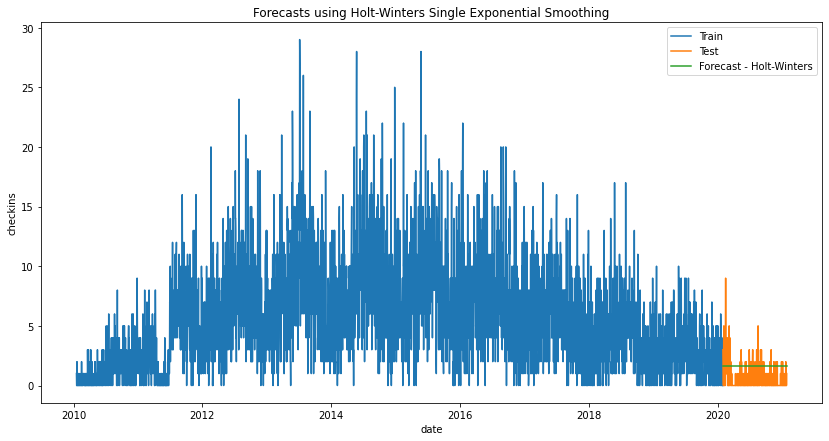

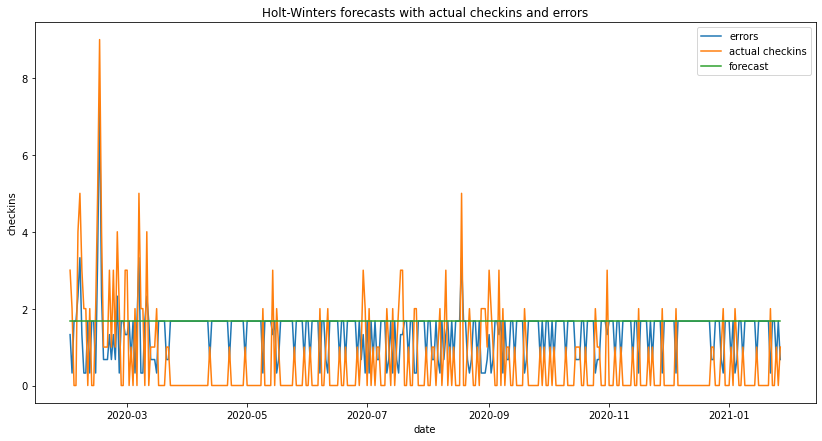

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
Exponential Smoothing,229,606.541085,-377.541085,1.375218,1.517745,217.392488


In [59]:
# Merge predictions and actual sales into one df
errors_df_hw = pd.merge(test_df, pred_fit_1, left_on='date', right_on='index')
errors_df_hw = errors_df_hw[['date', 'checkins', 'pred_checkins']]
errors_df_hw['errors'] = errors_df_hw.checkins - errors_df_hw.pred_checkins
errors_df_hw.insert(0, 'model', 'Exponential Smoothing')


# Evaluate the predictions for Holt-Winters without damping trend component
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['checkins'], label='Train')
plt.plot(test_df['date'], test_df['checkins'], label='Test')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_checkins'], label='Forecast - Holt-Winters')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Forecasts using Holt-Winters Single Exponential Smoothing')
plt.show()


plt.figure(figsize=(14,7))
plt.plot(errors_df_hw['date'], np.abs(errors_df_hw['errors']), label='errors')
plt.plot(errors_df_hw['date'], errors_df_hw['checkins'], label='actual checkins')
plt.plot(errors_df_hw['date'], errors_df_hw['pred_checkins'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Holt-Winters forecasts with actual checkins and errors')
plt.show()

result_df_hw = errors_df_hw.groupby('model').agg(total_checkins=('checkins', 'sum'),
                                          total_pred_checkins=('pred_checkins', 'sum'),
                                          overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_hw

Let's look at another popular time-series method: Autoregressive Integrated Moving Average (ARIMA) Model.

## 3. Autoregressive Integrated Moving Average - ARIMA Model

**Step 1: Check stationarity**

Before going any further into our analysis, our series has to be made stationary.

Stationarity is the property of exhibiting constant statistical properties (mean, variance, autocorrelation, etc.). If the mean of a time-series increases over time, then it’s not stationary.

The mean across many time periods is only informative if the expected value is the same across those time periods. If these population parameters can vary, what are we really estimating by taking an average across time?

Stationarity requires that the statistical properties must be the same across time, making the sample average a reasonable way to estimate them.

**Methods to Check Stationarity**

1. **Plotting rolling statistics:** Plotting rolling means and variances is a first good way to visually inspect our series. If the rolling statistics exhibit a clear trend (upwards or downwards) and show varying variance (increasing or decreasing amplitude), then you might conclude that the series is very likely not to be stationary.
2. **Augmented Dickey-Fuller Test:** This test is used to assess whether or not a time-series is stationary. It gives a result called a “test-statistic”, based on which you can say, with different levels (or percentage) of confidence, if the time-series is stationary or not. The test statistic is expected to be negative; therefore, it has to be more negative(less) than the critical value for the hypothesis to be rejected and conclude that series is stationary.
3. **ACF and PACF plots:** An autocorrelation (ACF) plot represents the autocorrelation of the series with lags of itself. A partial autocorrelation (PACF) plot represents the amount of correlation between a series and a lag of itself that is not explained by correlations at all lower-order lags. Ideally, we want no correlation between the series and lags of itself. Graphically speaking, we would like all the spikes to fall in the blue region.

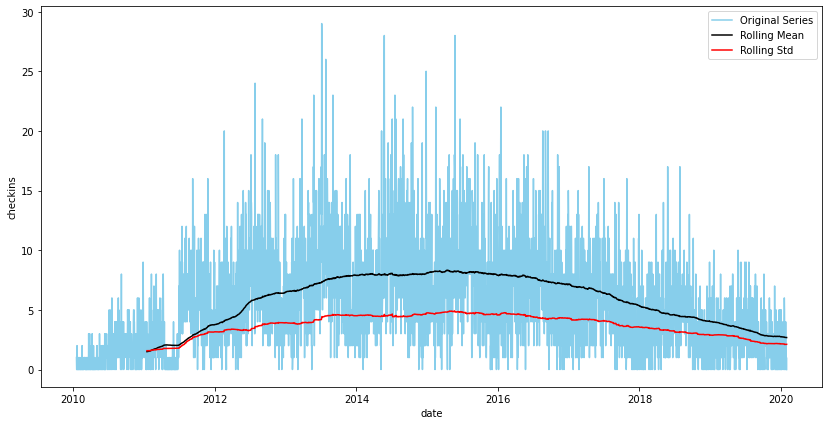

Test statistic = -3.220
P-value = 0.019
Critical values :
	1%: -3.432149263499404 - The data is not stationary with 99% confidence
	5%: -2.8623350143451307 - The data is  stationary with 95% confidence
	10%: -2.5671931983337477 - The data is  stationary with 90% confidence


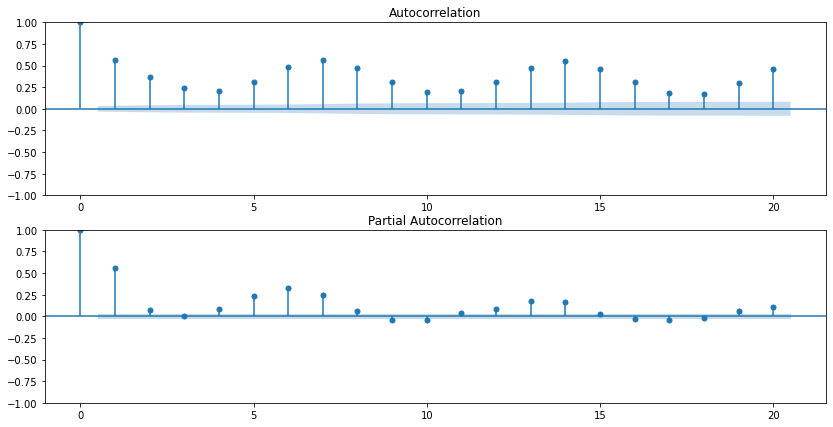

In [24]:
arima_df = train_df[['date', 'checkins']].set_index('date')
arima_test_df = test_df[['date', 'checkins']].set_index('date')

def test_stationarity(timeseries):
    # Plotting rolling statistics
    rollmean = timeseries.rolling(window=365).mean()
    rollstd = timeseries.rolling(window=365).std()

    plt.figure(figsize=(14,7))
    plt.plot(timeseries, color='skyblue', label='Original Series')
    plt.plot(rollmean, color='black', label='Rolling Mean')
    plt.plot(rollstd, color='red', label='Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('date')
    plt.ylabel('checkins')
    plt.show()
    
    # Augmented Dickey-Fuller Test
    adfuller_test = adfuller(timeseries, autolag='AIC')
    print("Test statistic = {:.3f}".format(adfuller_test[0]))
    print("P-value = {:.3f}".format(adfuller_test[1]))
    print("Critical values :")
    
    for key, value in adfuller_test[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence"
              .format(key, value, '' if adfuller_test[0] < value else 'not', 100-int(key[:-1])))
        
    # Autocorrelation Plots
    fig, ax = plt.subplots(2, figsize=(14,7))
    ax[0] = plot_acf(timeseries, ax=ax[0], lags=20)
    ax[1] = plot_pacf(timeseries, ax=ax[1], lags=20)
    
test_stationarity(arima_df.checkins)

Looking at the results from our test, we can conclude that the series is not stationary. 

Therefore, in order to make the series stationary we apply **Differencing**

**Step 2: Differencing**

**Differencing:** Seasonal or cyclical patterns can be removed by substracting periodical values. If the data is 12-month seasonal, substracting the series with a 12-lag difference series will give a “flatter” series. Since we have aggregated the data to each day-level, we will shift by 1.

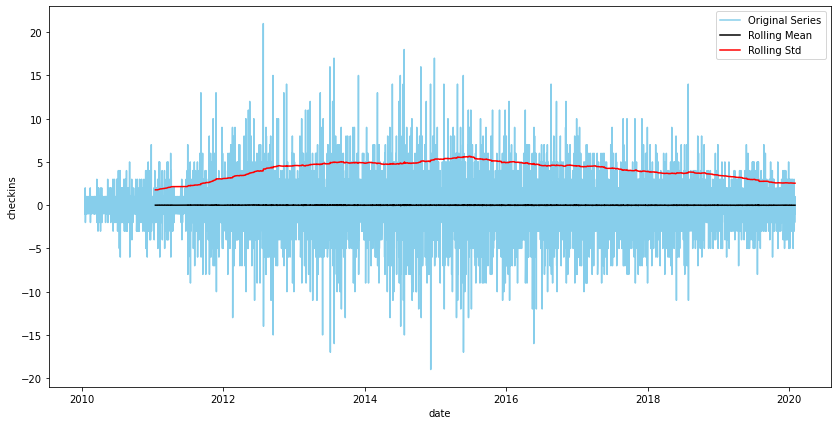

Test statistic = -18.528
P-value = 0.000
Critical values :
	1%: -3.432149263499404 - The data is  stationary with 99% confidence
	5%: -2.8623350143451307 - The data is  stationary with 95% confidence
	10%: -2.5671931983337477 - The data is  stationary with 90% confidence


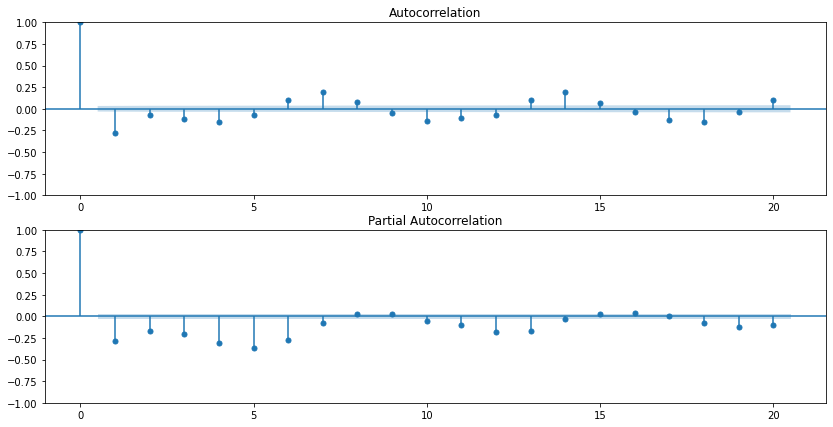

In [25]:
first_difference = arima_df.checkins - arima_df.checkins.shift(1)
first_difference = pd.DataFrame(first_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(first_difference.checkins)

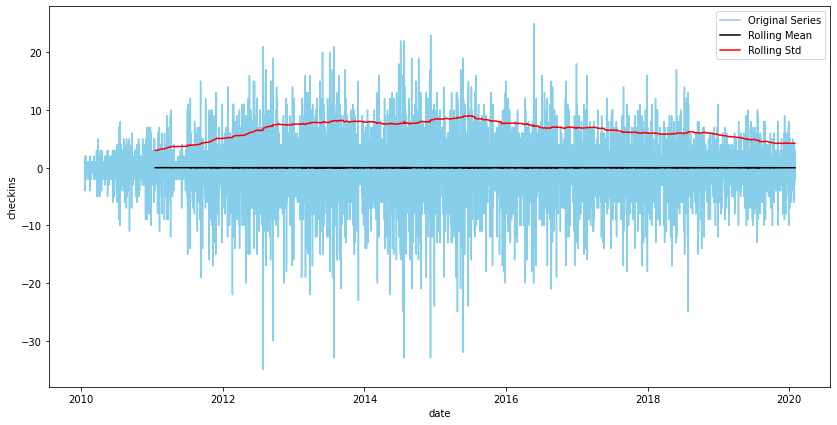

Test statistic = -24.924
P-value = 0.000
Critical values :
	1%: -3.432150254165979 - The data is  stationary with 99% confidence
	5%: -2.8623354519441797 - The data is  stationary with 95% confidence
	10%: -2.567193431297053 - The data is  stationary with 90% confidence


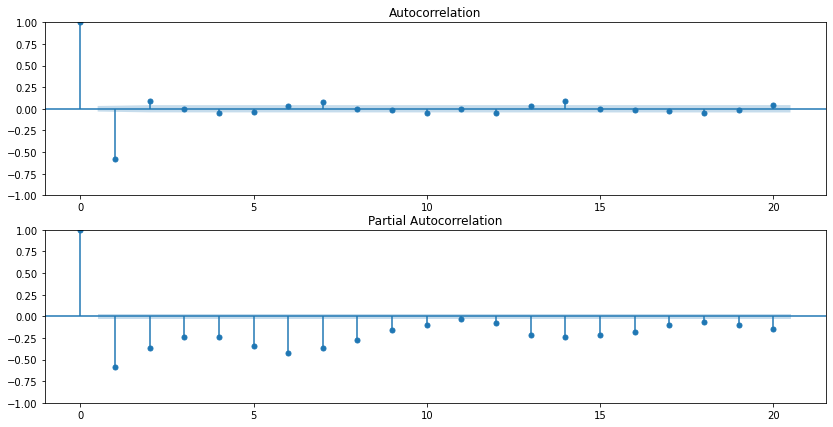

In [26]:
second_difference = first_difference.checkins - first_difference.checkins.shift(1)
second_difference = pd.DataFrame(second_difference.dropna(inplace=False))
# Check for stationarity after differencing
test_stationarity(second_difference.checkins)

After applying Differencing to the series, we can see from the above results that the series is now stationary, i.e. mean and variance are constant over time, and from ADF we can verify that the test-statistic is lesser than the critical value, hence we can reject the null hypothesis and conclude that the series is staionary.

**Step 3: Model Building**

Interpreting the AR(p), I(d), MA(q) values:

1. Determining I(d): Taking the first order difference makes the time series stationary. Therefore, I(d) = 1.

2. Determining AR(p): If the lag-1 autocorrelation of the differenced series PACF is negative, and/or there is a sharp cutoff, then choose a AR order of 1.

    - We can use AR(p) = 2, (if the partial autocorrelation is significant at lag k and not significant at any higher order lags--i.e., if the PACF "cuts off" at lag k--then this suggests that you should try fitting an autoregressive model of order k).


3. Determining MA(q): If the lag-1 autocorrelation of the differenced series ACF is negative, and/or there is a sharp cutoff, then choose a MA order of 1.

    - From tha ACF plot we see a negative spike at lag 1, therfore we can use MA(q) = 1

In [27]:
# arima_df.index = mplt_dates.date2num(arima_df.index)
arima_df = train_df[['date', 'checkins']]
checkins = arima_df.checkins.to_numpy()
dates = pd.date_range(str(min(arima_df.date).date()), freq='D', periods=len(arima_df.date))
train = pd.Series(checkins, index=dates)
train

2010-01-17    1
2010-01-18    0
2010-01-19    0
2010-01-20    2
2010-01-21    0
             ..
2020-01-27    1
2020-01-28    2
2020-01-29    0
2020-01-30    1
2020-01-31    0
Freq: D, Length: 3667, dtype: int64

In [28]:
arima_test_df = test_df[['date', 'checkins']]
checkins = arima_test_df.checkins.to_numpy()
dates = pd.date_range(str(min(arima_test_df.date).date()), freq='D', periods=len(arima_test_df.checkins))
test = pd.Series(checkins, index=dates)
test

2020-02-01    3
2020-02-02    2
2020-02-03    0
2020-02-04    0
2020-02-05    4
             ..
2021-01-23    0
2021-01-24    0
2021-01-25    1
2021-01-26    0
2021-01-27    1
Freq: D, Length: 362, dtype: int64

In [29]:
arima_model = ARIMA(train, order=(2,1,2)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3667
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -9552.025
Date:                Tue, 02 Nov 2021   AIC                          19114.049
Time:                        15:55:18   BIC                          19145.083
Sample:                    01-17-2010   HQIC                         19125.099
                         - 01-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9006      0.056     16.096      0.000       0.791       1.010
ar.L2         -0.3363      0.019    -18.099      0.000      -0.373      -0.300
ma.L1         -1.5217      0.057    -26.484      0.0

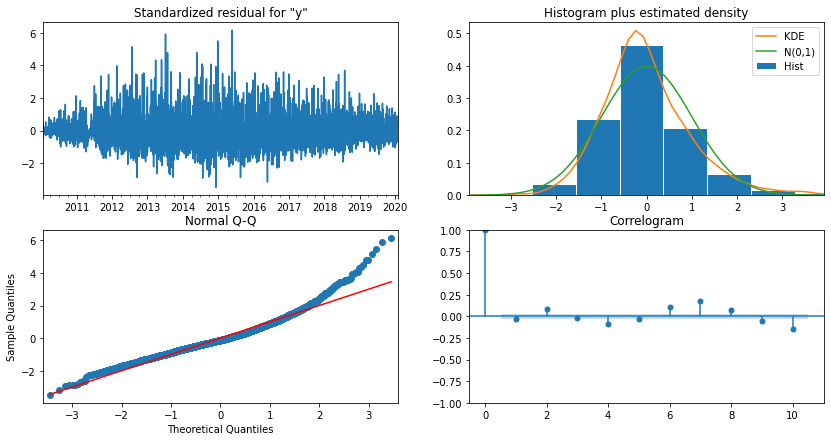

In [30]:
arima_test_df['pred_checkins'] = arima_model.forecast(steps=len(test))[0]
for i in range(len(test)):
    arima_test_df['pred_checkins'].iloc[i] = arima_model.forecast(steps=len(test))[i]
plot = arima_model.plot_diagnostics(figsize=(14,7))

### Plotting the residuals using ACF and PACF

Plotting the residuals shows that recurring correlation does not exist in both ACF and PACF. So we don't need to deal with seasonality. 

When the plots of ACF and PACF are similar or any sesaonality is present between them then, we need to apply the Seasonal ARIMA (SARIMA) model.

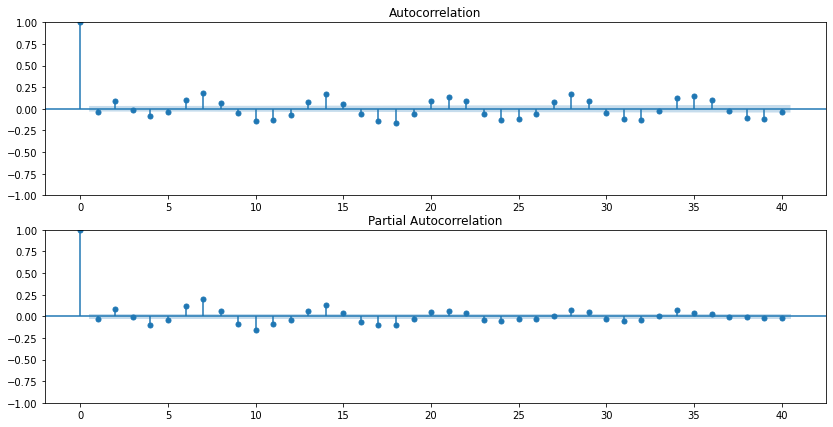

In [31]:
residuals = arima_model.resid
# Checking for seasonality
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(residuals, ax=ax[0], lags=40)
ax[1] = plot_pacf(residuals, ax=ax[1], lags=40)

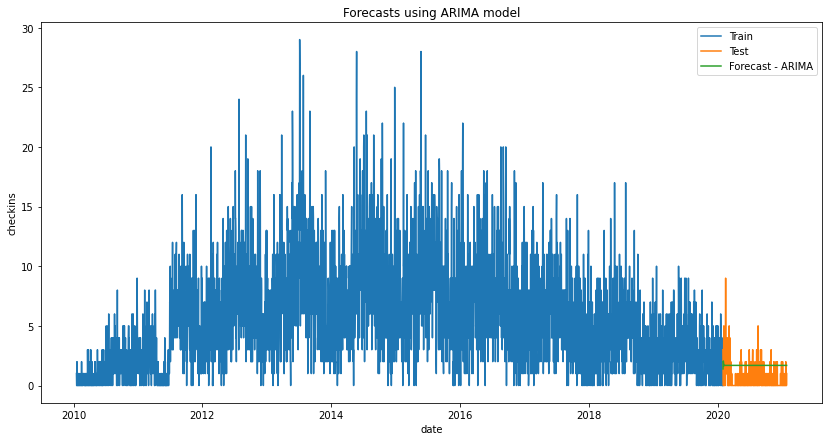

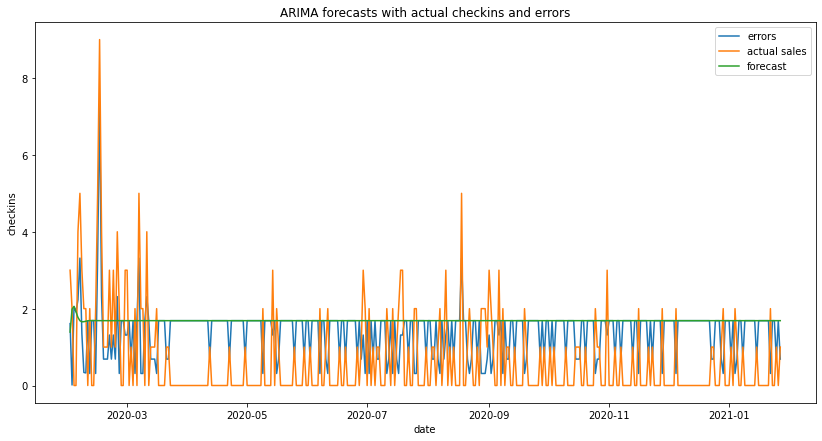

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
ARIMA,229,611.280987,-382.280987,1.384507,1.528057,218.860905


In [32]:
# eval
arima_test_df['errors'] = arima_test_df.checkins - arima_test_df.pred_checkins
arima_test_df.insert(0, 'model', 'ARIMA')

# Evaluate the predictions for Seasonal ARIMA model
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['checkins'], label='Train')
plt.plot(arima_test_df.date, arima_test_df['checkins'], label='Test')
plt.plot(arima_test_df.date, arima_test_df['pred_checkins'], label='Forecast - ARIMA')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Forecasts using ARIMA model')
plt.show()

plt.figure(figsize=(14,7))
plt.plot(arima_test_df.date, np.abs(arima_test_df['errors']), label='errors')
plt.plot(arima_test_df.date, arima_test_df['checkins'], label='actual sales')
plt.plot(arima_test_df.date, arima_test_df['pred_checkins'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('ARIMA forecasts with actual checkins and errors')
plt.show()

result_df_sarima = arima_test_df.groupby('model').agg(total_checkins=('checkins', 'sum'),
                                          total_pred_checkins=('pred_checkins', 'sum'),
                                          overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_sarima

## Supervised Machine Learning: Regression to forecast Restaurant Chekins

In [33]:
reg_df = rest1
reg_df

,date,checkins,year,month,week,day
0,2010-01-17,1,2010,1,2,17
1,2010-01-18,0,2010,1,3,18
2,2010-01-19,0,2010,1,3,19
3,2010-01-20,2,2010,1,3,20
4,2010-01-21,0,2010,1,3,21
...,...,...,...,...,...,...
4024,2021-01-23,0,2021,1,3,23
4025,2021-01-24,0,2021,1,3,24
4026,2021-01-25,1,2021,1,4,25
4027,2021-01-26,0,2021,1,4,26


<AxesSubplot:xlabel='checkins'>

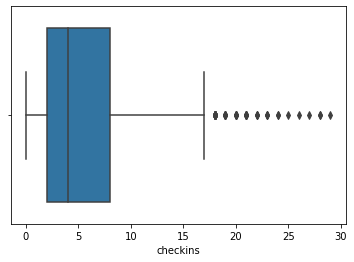

In [34]:
sn.boxplot(x=reg_df['checkins'])

[array([2., 0.]), array([ 8., 17.])]

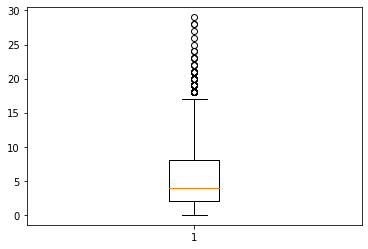

In [35]:
B = plt.boxplot(reg_df['checkins'])
[item.get_ydata() for item in B['whiskers']]

# Anything above 16 and less than 0 is a statistical outlier

<AxesSubplot:xlabel='week', ylabel='checkins'>

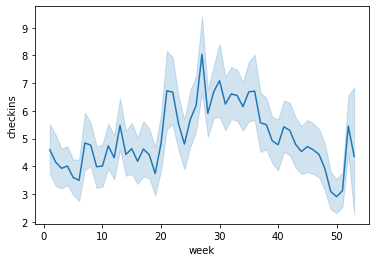

In [36]:
# Weekly trend
sn.lineplot(reg_df['week'], reg_df['checkins'])

<AxesSubplot:xlabel='year', ylabel='checkins'>

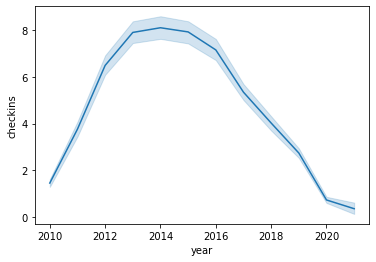

In [37]:
# Yearly trend
sn.lineplot(reg_df['year'], reg_df['checkins'])

In [38]:
# Removing Outliers

# We remove the outliers. As we know from the boxplots, 
# that anything above 16 and less than 0 is a statistical outlier

#reg_df = reg_df[reg_df['checkins'] < 16]
#reg_df = reg_df[reg_df['checkins'] > 0]

#reg_df

<AxesSubplot:xlabel='checkins'>

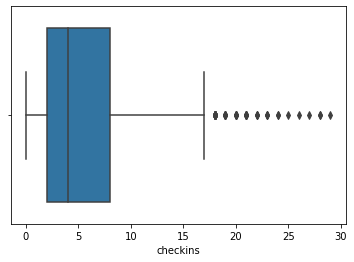

In [39]:
sn.boxplot(x=reg_df['checkins'])

In [40]:
# Step 1: Feature Engineering

# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.checkins.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.checkins.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.checkins.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.checkins.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)


# Split the series to predict the last 3 months of 2017
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2020-01-31']                        
reg_test_df = reg_df.loc['2020-02-01':]

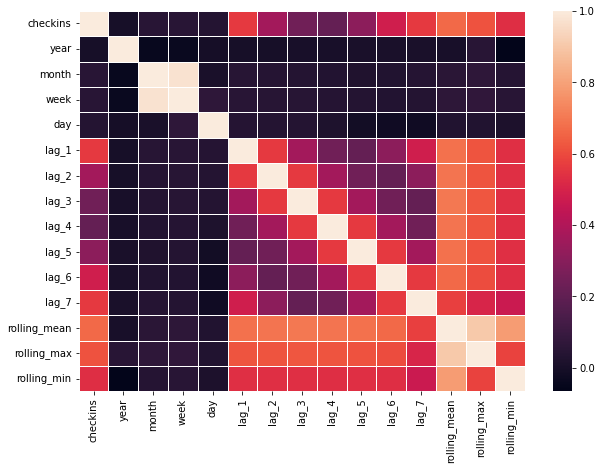

In [41]:
# Step 2: Feature Selection and Model Building

# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [42]:
X_train = reg_train_df.drop(['checkins'], axis=1)
y_train = reg_train_df['checkins'].values

X_test = reg_test_df.drop(['checkins'], axis=1)
y_test = reg_test_df['checkins'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k='all')
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature        Score
11  rolling_mean  2880.405468
12   rolling_max  2208.053950
10         lag_7  1672.613479
4          lag_1  1671.525744
13   rolling_min  1448.344460


In [43]:
# update X_train, X_test to include top features
#X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_1', 'lag_7']]
#X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_1', 'lag_7']]

In [44]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

In [45]:
# Compare models

def scores(m):
    model = m()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_r2 = r2_score(y_test, y_pred)
    s.append(model_r2)
    
models = [LinearRegression,
          ElasticNet,
          Lasso,
          KNeighborsRegressor,
          DecisionTreeRegressor,
          RandomForestRegressor,
          GradientBoostingRegressor]
s = []
for m in models:
    scores(m)
    
s

[1.0,
 0.25077048278394964,
 0.1907260576001324,
 -2.487563469299375,
 0.032115936207469886,
 0.3141748470146676,
 0.121265587015567]

### Random Forest

In [46]:
rf_model = RandomForestRegressor(oob_score=True,
                                 random_state=7, 
                                 max_features='auto', 
                                 min_samples_leaf=2)

In [47]:
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

In [48]:
r2_score(y_test, rf_preds)

0.40542103108360883

In [49]:
errors_df = reg_test_df[['checkins']]
errors_df['pred_checkins'] = rf_preds
errors_df['errors'] = rf_preds - y_test
errors_df.insert(0, 'model', 'RandomForestRegressor')

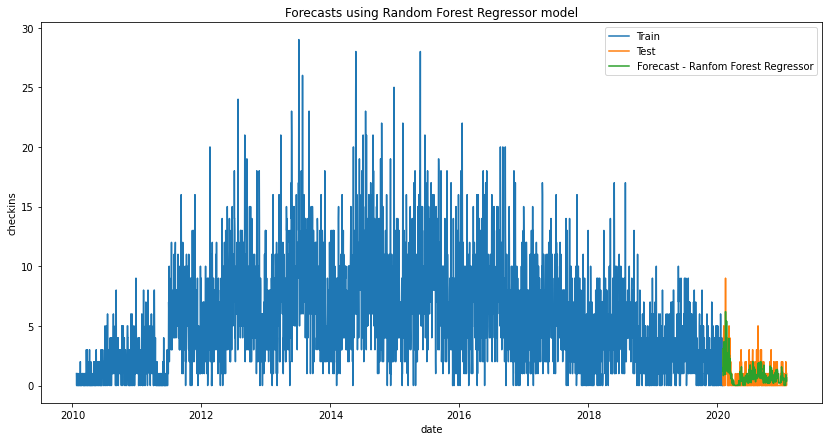

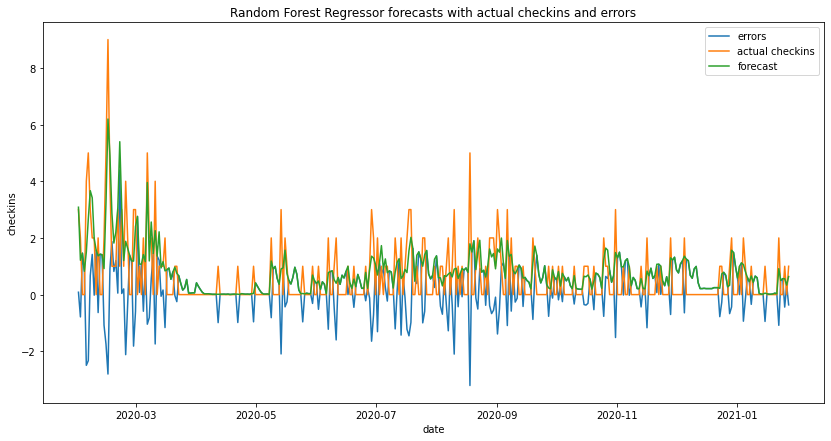

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
RandomForestRegressor,229,301.095409,72.095409,0.633595,0.850244,100.157852


In [50]:
# Step 3: Model Evaluation and Predictions

# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['checkins'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['checkins'], label='Test')
plt.plot(errors_df.index, errors_df['pred_checkins'], label='Forecast - Ranfom Forest Regressor')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Forecasts using Random Forest Regressor model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.checkins, label='actual checkins')
plt.plot(errors_df.index, errors_df.pred_checkins, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Random Forest Regressor forecasts with actual checkins and errors')
plt.show()

result_df_rf = errors_df.groupby('model').agg(total_checkins=('checkins', 'sum'),
                                          total_pred_checkins=('pred_checkins', 'sum'),
                                          overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_rf

### Linear Regression

In [51]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_1', 'lag_7']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_1', 'lag_7']]

In [52]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_test)
r2_score(y_test, lr_preds)

0.2435524650338815

In [53]:
errors_df = reg_test_df[['checkins']]
errors_df['pred_checkins'] = lr_preds
errors_df['errors'] = lr_preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

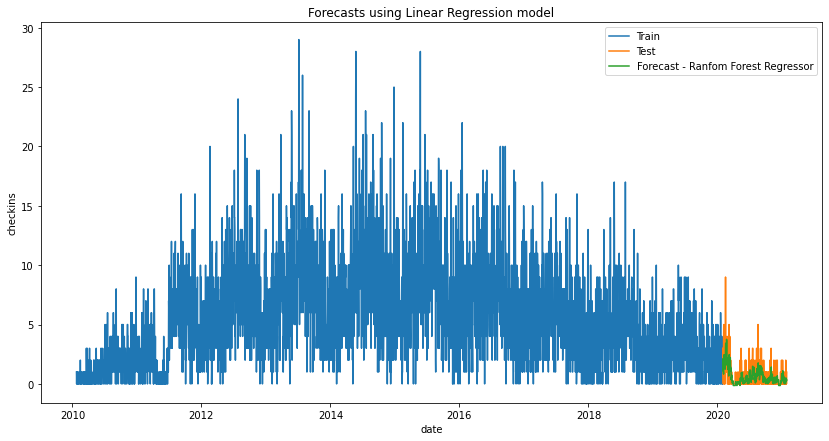

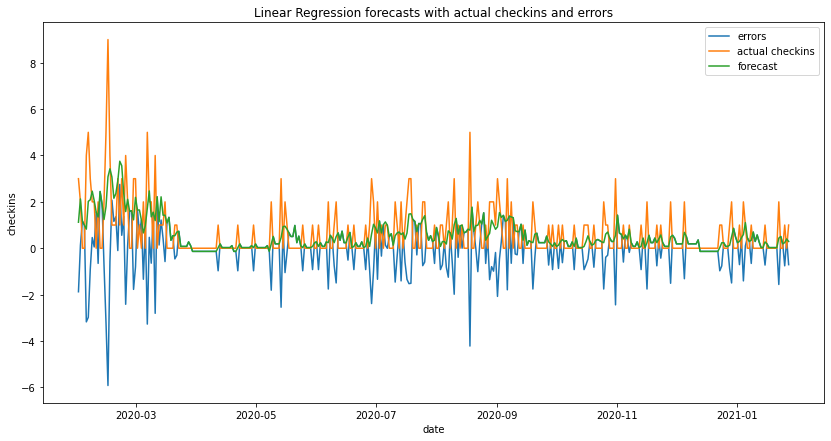

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,229,210.59946,-18.40054,0.647681,0.959021,102.384537


In [54]:
# Step 3: Model Evaluation and Predictions

# eval predictions
fig = plt.figure(figsize=(14,7))
plt.plot(reg_train_df.index, reg_train_df['checkins'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['checkins'], label='Test')
plt.plot(errors_df.index, errors_df['pred_checkins'], label='Forecast - Ranfom Forest Regressor')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(14,7))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.checkins, label='actual checkins')
plt.plot(errors_df.index, errors_df.pred_checkins, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('checkins')
plt.title('Linear Regression forecasts with actual checkins and errors')
plt.show()

result_df_lr = errors_df.groupby('model').agg(total_checkins=('checkins', 'sum'),
                                          total_pred_checkins=('pred_checkins', 'sum'),
                                          overall_error=('errors', 'sum'),
                                          MAE=('errors', mae),
                                          RMSE=('errors', rmse), 
                                          MAPE=('errors', mape))
result_df_lr

In [55]:
pd.concat([result_df, 
           result_df_hw,
           result_df_sarima,
           result_df_rf,
           result_df_lr
          ])

,total_checkins,total_pred_checkins,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,229,977.000000,-748.000000,2.414365,3.123605,381.659389
Exponential Smoothing,229,606.541085,-377.541085,1.375218,1.517745,217.392488
ARIMA,229,611.280987,-382.280987,1.384507,1.528057,218.860905
RandomForestRegressor,229,301.095409,72.095409,0.633595,0.850244,100.157852
LinearRegression,229,210.599460,-18.400540,0.647681,0.959021,102.384537
